In [1]:
#%%
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import random
import numpy as np
import copy
import torch
import learn2learn as l2l
from tqdm import tqdm
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform_norm
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

########################### experiment name ###########################

# seed
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

###########################  hyperparametes  ###########################
EPOCH = 200   
# enumalate the whole data once takes 180 outer loop
Inner_EPOCH = 1

K = 5      # K examples for inner loop training
K_update = 1
adapt_steps = 5
adapt_lr = 0.001   # adapt θ': α
meta_lr = 0.0001    # update real model θ: β

###########################  data & dataloader  ###########################
num_train_subset = 30
num_val_subset = 10
fewshot = 10

# data path
path_train1 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_train_PD_Skyra_15-22.yaml'
path_train2 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_train_PDFS_Aera_15-22.yaml'
#path_train3 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/brain_train_T1POST_TrioTim5-8.yaml'
path_val1 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_val_PD_Skyra_15-22.yaml'
path_val2 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_val_PDFS_Aera_15-22.yaml'
#path_val3 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/brain_val_T1POST_TrioTim5-8.yaml'

path_tuning1 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_train_PD_Skyra_15-22.yaml'
path_tuning2 = '/cheng/metaMRI/metaMRI/data_dict_narrowSlices/E6.1/knee_train_PDFS_Aera_15-22.yaml'


# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)

data_transform_train = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=False)
data_transform_test = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True)

# dataset
trainset_1 =  SliceDataset(dataset = path_train1, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_train, use_dataset_cache=True, num_samples= num_train_subset)
trainset_2 =  SliceDataset(dataset = path_train2, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_train, use_dataset_cache=True, num_samples= num_train_subset)

tuning_set1 = SliceDataset(dataset = path_tuning1, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_train, use_dataset_cache=True, num_samples= fewshot)
tuning_set2 = SliceDataset(dataset = path_tuning2, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_train, use_dataset_cache=True, num_samples= fewshot)

val_set1 =  SliceDataset(dataset = path_val1, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_test, use_dataset_cache=True, num_samples= num_val_subset)
val_set2 =  SliceDataset(dataset = path_val2, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                challenge="multicoil", transform=data_transform_test, use_dataset_cache=True, num_samples= num_val_subset)

# dataloader
train_dataloader_1 = torch.utils.data.DataLoader(dataset = trainset_1, batch_size = K + K_update,
                    shuffle = True, generator = torch.Generator().manual_seed(1), pin_memory = True)
train_dataloader_2 = torch.utils.data.DataLoader(dataset = trainset_2, batch_size = K + K_update,
                    shuffle = True, generator = torch.Generator().manual_seed(1), pin_memory = True)

tuning_dataloader_1 = torch.utils.data.DataLoader(dataset = tuning_set1, batch_size = 1, 
                    shuffle = True, generator = torch.Generator().manual_seed(1), pin_memory = False)
tuning_dataloader_2 = torch.utils.data.DataLoader(dataset = tuning_set2, batch_size = 1, 
                    shuffle = True, generator = torch.Generator().manual_seed(1), pin_memory = False)

validation_dataloader_1 = torch.utils.data.DataLoader(dataset = val_set1, batch_size = 1, 
                    shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)
validation_dataloader_2 = torch.utils.data.DataLoader(dataset = val_set2, batch_size = 1, 
                    shuffle = False, generator = torch.Generator().manual_seed(1), pin_memory = False)



#%% Check the data 
###########################  model  ###########################
model = Unet(in_chans = 1,out_chans = 1,chans = 32, num_pool_layers = 4,drop_prob = 0.0)
#model = nn.DataParallel(model).to(device)
model = model.to(device)
maml = l2l.algorithms.MAML(model, lr=adapt_lr, first_order=False, allow_unused=True)


###########################  MAML training  ###########################
optimizer = optim.Adam(maml.parameters(), meta_lr)
ssim_fct = SSIMLoss()



In [2]:
# update real model
model.train()

# shuffle the data and generate iterator
iterator_train_1 = iter(train_dataloader_1)
iterator_train_2 = iter(train_dataloader_2)
iterator_list = [iterator_train_1, iterator_train_2]

# generate a list for random sample specific dataloader
sample_list = [0]*len(train_dataloader_1) + [1]*len(train_dataloader_2)
random.shuffle(sample_list)

# enumerate one distribution/task

# use the list to get the random train dataloader

In [3]:
###### 2: outer loop ######
# here we consider 180 outer loop as one training loop
meta_training_loss = 0.0
###### 3. Sample batch of tasks Ti ~ p(T) ######
# sample 2 batch at one time

In [4]:
index = 0

print('Outer loop: ', int((index/Inner_EPOCH)+1))
# index = 0, 2, 4, ...
i = sample_list[index : index+Inner_EPOCH]
# i = [ , ]
total_update_loss = 0.0
###### 4: inner loop ######
# Ti only contain one task: (K+K_update) data
for inner_iter in range(Inner_EPOCH):
    print('Inner loop: ', inner_iter+1)
    # load one batch from random dataloader
    iterator = iterator_list[i[inner_iter]]  # i = [ , ], 1st loop i[0], 2nd loop i[1]
    task_batch = next(iterator)

    # load K + K_update data
    input_image, target_image, mean, std, fname, slice_num = task_batch

    ### sample k examples to do adaption on learner: K = 4
    K_examples_inputs = input_image[0:K].to(device)
    K_examples_targets = target_image[0:K].to(device)
    K_mean = mean[0:K].to(device)
    K_std = std[0:K].to(device)

    # base learner
    learner = maml.clone()      #learner = torch.nn.DataParallel(learner, device_ids=[0,1,2,3])

    # adapt learner several step to K examples
    for _ in range(adapt_steps): 
        ###### 5. Evaluate ∇θLTi(fθ) with respect to K examples ######
        K_examples_preds = learner(K_examples_inputs)
        K_examples_preds = K_examples_preds * K_std + K_mean
        adapt_loss = ssim_fct(K_examples_preds, K_examples_targets, data_range = K_examples_targets.max().unsqueeze(0))
        ###### 6. Compute  adapted  parameters  with  gradient  descent: θ′i = θ − α∇θLTi(fθ) ######
        print('adapt loss: ', adapt_loss)
        learner.adapt(adapt_loss)
    
    # sample the K_update example for updating the model
    update_inputs = input_image[K:(K+K_update)].to(device)
    update_targets = target_image[K:(K+K_update)].to(device)
    update_mean = mean[K:(K+K_update)].to(device)
    update_std = std[K:(K+K_update)].to(device)

    ###### 7: inner loop end ######
    # for calculation efficient, some loss are still cumputed in this loop

    ####### 8. Update θ ← θ−β∇θ∑Ti∼p(T)LTi(fθ′i)   ######   
    # LTi(fθ′i)
    update_output = learner(update_inputs)
    update_output = update_output * update_std + update_mean
    update_loss = ssim_fct(update_output, update_targets, data_range = update_targets.max().unsqueeze(0))
    print('update loss: ', update_loss)
    # ∑Ti∼p(T)LTi(fθ′i): Ti only contain one task
    total_update_loss += update_loss
    print('total update loss: ', total_update_loss)

# del task_batch  # avoid cpu memory leak
# del learner     # gpu

# Update θ ← θ−β∇θ∑Ti∼p(T)LTi(fθ′i)
optimizer.zero_grad()
total_update_loss.backward()
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1, norm_type=2.)
optimizer.step()
# total_update_loss should be the meta training loss, 
# but we want some value can evaluate the training through whole dataset
# we use the mean of 180 outer loop loss as the meta training loss
meta_training_loss += total_update_loss.item()

Outer loop:  1
Inner loop:  1
adapt loss:  tensor(0.5522, device='cuda:0', grad_fn=<RsubBackward1>)
adapt loss:  tensor(0.5474, device='cuda:0', grad_fn=<RsubBackward1>)
adapt loss:  tensor(0.5426, device='cuda:0', grad_fn=<RsubBackward1>)
adapt loss:  tensor(0.5380, device='cuda:0', grad_fn=<RsubBackward1>)
adapt loss:  tensor(0.5335, device='cuda:0', grad_fn=<RsubBackward1>)
update loss:  tensor(0.6208, device='cuda:0', grad_fn=<RsubBackward1>)
total update loss:  tensor(0.6208, device='cuda:0', grad_fn=<AddBackward0>)


In [5]:
model(update_inputs)

tensor([[[[-0.4915, -0.6421, -0.2241,  ..., -0.5714, -0.5341, -0.4693],
          [-0.1398, -1.1568,  0.0458,  ..., -0.2026,  0.2692,  0.1277],
          [ 0.2382, -0.4921,  0.0739,  ..., -0.3947, -0.0649, -0.8101],
          ...,
          [-0.1619, -0.8655, -0.1940,  ...,  1.5039,  0.2310,  0.2027],
          [ 0.2476, -0.1312,  0.2088,  ...,  0.2764, -0.1093, -0.0102],
          [-0.1692, -0.4687,  0.3195,  ..., -0.2177,  0.3570, -0.2179]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

In [6]:
K_examples_inputs

tensor([[[[-0.8209, -0.7338, -0.8398,  ..., -0.6207, -0.8455, -0.8755],
          [-0.7766, -1.0706, -0.9202,  ..., -0.8474, -0.8790, -1.1510],
          [-1.0827, -0.7937, -1.0978,  ..., -1.2893, -0.6103, -0.7747],
          ...,
          [-0.7628, -0.7529, -0.9233,  ..., -1.0061, -0.8287, -0.9348],
          [-0.7774, -0.9842, -0.4850,  ..., -0.7165, -0.6146, -0.5771],
          [-0.9216, -0.6796, -0.9102,  ..., -1.0538, -0.6210, -1.0211]]],


        [[[-0.7519, -0.9283, -0.8385,  ..., -0.8863, -0.8613, -0.7616],
          [-0.8980, -0.9210, -0.7512,  ..., -0.7607, -0.8101, -0.8605],
          [-0.8832, -0.9847, -0.9264,  ..., -0.8832, -0.9024, -0.8691],
          ...,
          [-0.7511, -0.6710, -0.6971,  ..., -0.9153, -0.8876, -0.8966],
          [-0.9169, -0.7241, -0.8121,  ..., -0.9440, -0.7782, -0.9118],
          [-0.7946, -0.8035, -0.7797,  ..., -0.8428, -0.7332, -0.7729]]],


        [[[-1.3234, -1.1366, -1.0151,  ..., -1.0974, -1.1102, -1.2804],
          [-1.2532, -1.213

In [7]:
a = K_examples_inputs

In [8]:
K_examples_preds

tensor([[[[1.1451e-05, 8.5239e-06, 1.1490e-05,  ..., 9.5067e-06,
           1.2615e-05, 8.9397e-06],
          [1.2872e-05, 7.3017e-06, 1.3230e-05,  ..., 1.1625e-05,
           1.3656e-05, 1.4902e-05],
          [1.3859e-05, 1.0266e-05, 1.4150e-05,  ..., 1.2043e-05,
           1.3698e-05, 1.1072e-05],
          ...,
          [1.0263e-05, 7.6197e-06, 1.3152e-05,  ..., 9.7737e-06,
           1.1847e-05, 1.1340e-05],
          [1.4025e-05, 1.1275e-05, 1.2518e-05,  ..., 1.1555e-05,
           1.3361e-05, 1.4115e-05],
          [1.1490e-05, 1.1366e-05, 1.3558e-05,  ..., 1.2540e-05,
           1.0464e-05, 1.2097e-05]]],


        [[[1.5165e-05, 1.2646e-05, 1.8716e-05,  ..., 1.1363e-05,
           1.5085e-05, 1.7546e-05],
          [1.9146e-05, 6.6068e-06, 1.8171e-05,  ..., 2.1598e-05,
           2.4004e-05, 2.3999e-05],
          [2.4308e-05, 1.5778e-05, 2.5011e-05,  ..., 1.7547e-05,
           2.1052e-05, 1.1386e-05],
          ...,
          [1.9778e-05, 1.2636e-05, 1.7836e-05,  ..., 1.16

In [9]:
index = 1

print('Outer loop: ', int((index/Inner_EPOCH)+1))
# index = 0, 2, 4, ...
i = sample_list[index : index+Inner_EPOCH]
# i = [ , ]
total_update_loss = 0.0
###### 4: inner loop ######

Outer loop:  2


In [10]:
print('Inner loop: ', inner_iter+1)
# load one batch from random dataloader
iterator = iterator_list[i[inner_iter]]  # i = [ , ], 1st loop i[0], 2nd loop i[1]
task_batch = next(iterator)

# load K + K_update data
input_image, target_image, mean, std, fname, slice_num = task_batch

### sample k examples to do adaption on learner: K = 4
K_examples_inputs = input_image[0:K].to(device)
K_examples_targets = target_image[0:K].to(device)
K_mean = mean[0:K].to(device)
K_std = std[0:K].to(device)

# base learner
learner = maml.clone()      #learner = torch.nn.DataParallel(learner, device_ids=[0,1,2,3])

Inner loop:  1


In [11]:
K_examples_inputs

tensor([[[[-1.0268, -1.1933, -0.9825,  ..., -0.9372, -1.3013, -1.0586],
          [-1.1827, -0.9763, -0.8037,  ..., -0.9143, -0.9381, -1.0828],
          [-1.0919, -1.2738, -1.1817,  ..., -1.0360, -1.1132, -0.9336],
          ...,
          [-0.7251, -1.1178, -0.8176,  ..., -0.9679, -0.9306, -0.8563],
          [-0.9306, -0.9929, -0.8962,  ..., -0.8267, -0.9445, -1.1289],
          [-0.8915, -1.1999, -0.8994,  ..., -0.6960, -0.8417, -1.1335]]],


        [[[-1.1148, -0.8480, -1.0844,  ..., -1.0912, -1.0610, -1.0006],
          [-1.0034, -0.9124, -0.9840,  ..., -1.0215, -1.0841, -1.1884],
          [-1.1450, -1.0744, -1.0061,  ..., -1.1010, -0.9811, -1.1807],
          ...,
          [-1.0702, -1.0318, -0.9439,  ..., -1.0170, -0.9049, -0.8437],
          [-0.9560, -1.0085, -1.2459,  ..., -0.8293, -0.9312, -0.9727],
          [-0.6593, -0.7925, -0.9754,  ..., -1.0060, -1.1188, -0.9423]]],


        [[[-1.0329, -0.9880, -0.9522,  ..., -1.0030, -0.9559, -0.8206],
          [-0.8799, -0.914

In [12]:
b = K_examples_inputs

In [13]:
K_examples_preds = learner(K_examples_inputs)
K_examples_preds

tensor([[[[-4.6600e-01, -6.4284e-01, -8.3086e-02,  ..., -6.3365e-01,
           -5.5387e-01, -4.2562e-01],
          [-5.2028e-03, -8.7306e-01, -2.8663e-02,  ..., -4.1251e-02,
            4.6622e-01,  5.1412e-01],
          [ 1.7863e-01, -2.8778e-01,  1.7979e-01,  ..., -1.3626e-01,
           -1.0253e-01, -5.7470e-01],
          ...,
          [-2.8726e-01, -5.5588e-01, -1.6067e-01,  ..., -3.9202e-01,
           -4.3094e-02, -3.0176e-01],
          [ 6.1663e-02, -2.4630e-01, -4.4800e-02,  ..., -1.7880e-01,
            2.4067e-01, -1.4059e-01],
          [-1.5200e-01, -3.3493e-01, -1.0710e-01,  ..., -2.0880e-01,
           -1.5159e-01, -2.5743e-01]]],


        [[[-3.2669e-01, -5.1175e-01, -1.3065e-01,  ..., -6.9356e-01,
           -2.6977e-01, -3.0510e-01],
          [-1.5489e-01, -8.7153e-01, -6.5928e-02,  ...,  1.3475e-01,
            3.4569e-01,  2.2156e-01],
          [ 1.9744e-01, -2.0227e-01,  3.3559e-01,  ..., -5.1112e-01,
            1.4961e-01, -6.0106e-01],
          ...,
   

In [ ]:
    K_examples_preds = K_examples_preds * K_std + K_mean
    adapt_loss = ssim_fct(K_examples_preds, K_examples_targets, data_range = K_examples_targets.max().unsqueeze(0))
    ###### 6. Compute  adapted  parameters  with  gradient  descent: θ′i = θ − α∇θLTi(fθ) ######
    print('adapt loss: ', adapt_loss)
    learner.adapt(adapt_loss)

In [ ]:
# adapt learner several step to K examples
for _ in range(adapt_steps): 
    ###### 5. Evaluate ∇θLTi(fθ) with respect to K examples ######
    K_examples_preds = learner(K_examples_inputs)
    K_examples_preds = K_examples_preds * K_std + K_mean
    adapt_loss = ssim_fct(K_examples_preds, K_examples_targets, data_range = K_examples_targets.max().unsqueeze(0))
    ###### 6. Compute  adapted  parameters  with  gradient  descent: θ′i = θ − α∇θLTi(fθ) ######
    print('adapt loss: ', adapt_loss)
    learner.adapt(adapt_loss)

# sample the K_update example for updating the model
update_inputs = input_image[K:(K+K_update)].to(device)
update_targets = target_image[K:(K+K_update)].to(device)
update_mean = mean[K:(K+K_update)].to(device)
update_std = std[K:(K+K_update)].to(device)

###### 7: inner loop end ######
# for calculation efficient, some loss are still cumputed in this loop

####### 8. Update θ ← θ−β∇θ∑Ti∼p(T)LTi(fθ′i)   ######   
# LTi(fθ′i)
update_output = learner(update_inputs)
update_output = update_output * update_std + update_mean
update_loss = ssim_fct(update_output, update_targets, data_range = update_targets.max().unsqueeze(0))
print('update loss: ', update_loss)
# ∑Ti∼p(T)LTi(fθ′i): Ti only contain one task
total_update_loss += update_loss
print('total update loss: ', total_update_loss)


In [ ]:

### one training loop include 180 outer loop
for iter_ in range(EPOCH):    
    print('Iteration:', iter_+1)

    # update real model
    model.train()

    # shuffle the data and generate iterator
    iterator_train_1 = iter(train_dataloader_1)
    iterator_train_2 = iter(train_dataloader_2)
    iterator_list = [iterator_train_1, iterator_train_2]

    # generate a list for random sample specific dataloader
    sample_list = [0]*len(train_dataloader_1) + [1]*len(train_dataloader_2)
    random.shuffle(sample_list)

    # enumerate one distribution/task

    # use the list to get the random train dataloader

    ###### 2: outer loop ######
    # here we consider 180 outer loop as one training loop
    meta_training_loss = 0.0
    ###### 3. Sample batch of tasks Ti ~ p(T) ######
    # sample 2 batch at one time
    for index in tqdm(range(0, len(sample_list), Inner_EPOCH)):   
        print('Outer loop: ', int((index/Inner_EPOCH)+1))
        # index = 0, 2, 4, ...
        i = sample_list[index : index+Inner_EPOCH]
        # i = [ , ]
        total_update_loss = 0.0
        ###### 4: inner loop ######
        # Ti only contain one task: (K+K_update) data
        for inner_iter in range(Inner_EPOCH):
            print('Inner loop: ', inner_iter+1)
            # load one batch from random dataloader
            iterator = iterator_list[i[inner_iter]]  # i = [ , ], 1st loop i[0], 2nd loop i[1]
            task_batch = next(iterator)

            # load K + K_update data
            input_image, target_image, mean, std, fname, slice_num = task_batch

            ### sample k examples to do adaption on learner: K = 4
            K_examples_inputs = input_image[0:K].to(device)
            K_examples_targets = target_image[0:K].to(device)
            K_mean = mean[0:K].to(device)
            K_std = std[0:K].to(device)

            # base learner
            learner = maml.clone()      #learner = torch.nn.DataParallel(learner, device_ids=[0,1,2,3])

            # adapt learner several step to K examples
            for _ in range(adapt_steps): 
                ###### 5. Evaluate ∇θLTi(fθ) with respect to K examples ######
                K_examples_preds = learner(K_examples_inputs)
                K_examples_preds = K_examples_preds * K_std + K_mean
                adapt_loss = ssim_fct(K_examples_preds, K_examples_targets, data_range = K_examples_targets.max().unsqueeze(0))
                ###### 6. Compute  adapted  parameters  with  gradient  descent: θ′i = θ − α∇θLTi(fθ) ######
                learner.adapt(adapt_loss)
            
            # sample the K_update example for updating the model
            update_inputs = input_image[K:(K+K_update)].to(device)
            update_targets = target_image[K:(K+K_update)].to(device)
            update_mean = mean[K:(K+K_update)].to(device)
            update_std = std[K:(K+K_update)].to(device)

            ###### 7: inner loop end ######
            # for calculation efficient, some loss are still cumputed in this loop

            ####### 8. Update θ ← θ−β∇θ∑Ti∼p(T)LTi(fθ′i)   ######   
            # LTi(fθ′i)
            update_output = learner(update_inputs)
            update_output = update_output * update_std + update_mean
            update_loss = ssim_fct(update_output, update_targets, data_range = update_targets.max().unsqueeze(0))
            # ∑Ti∼p(T)LTi(fθ′i): Ti only contain one task
            total_update_loss += update_loss

        # del task_batch  # avoid cpu memory leak
        # del learner     # gpu

        # Update θ ← θ−β∇θ∑Ti∼p(T)LTi(fθ′i)
        optimizer.zero_grad()
        total_update_loss.backward()
        optimizer.step()
        # total_update_loss should be the meta training loss, 
        # but we want some value can evaluate the training through whole dataset
        # we use the mean of 180 outer loop loss as the meta training loss
        meta_training_loss += total_update_loss.item()

    print("Meta Training SSIM (MAML)", (1-meta_training_loss/len(sample_list)))


In [72]:
update_output

tensor([[[[ 0.5132,  0.5010,  0.4559,  ...,  0.2799,  0.4261,  0.2362],
          [ 0.4783, -0.0531, -0.3000,  ...,  0.0961, -0.2918, -0.0803],
          [ 0.9138,  0.5749, -0.2769,  ..., -0.0272,  0.0642, -0.0945],
          ...,
          [ 0.5682,  0.2881,  0.1568,  ...,  0.3287, -0.2166, -0.1379],
          [ 0.3566,  0.2873,  0.2679,  ...,  0.5952,  0.3296,  0.4441],
          [ 0.5450,  0.6209,  0.5329,  ...,  0.5605,  0.2507,  0.5107]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)

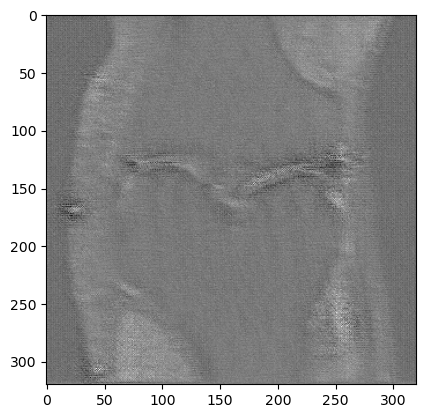

In [73]:
import matplotlib.pyplot as plt
plt.imshow(update_output.squeeze(0).squeeze(0).cpu().detach().numpy(),cmap='gray')
plt.show()

In [19]:
update_output.shape

torch.Size([1, 1, 320, 320])

In [18]:
update_loss = ssim_fct(update_output, update_targets, data_range = update_targets.max().unsqueeze(0))
update_loss

tensor(0., device='cuda:0')